In [2]:
!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common

!apt-get install -y patchelf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgl1-mesa-dev is already the newest version (20.0.8-0ubuntu1~18.04.1).
libgl1-mesa-dev set to manually installed.
software-properties-common is already the newest version (0.96.24.32.18).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
Suggested packages:
  glew-utils
The following NEW packages will be installed:
  libgl1-mesa-glx libglew-dev libglew2.0 libosmesa6 libosmesa6-dev
0 upgraded, 5 newly installed, 0 to remove and 20 not upgraded.
Need to get 2,916 kB of archives.
After this operation, 12.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libgl1-mesa-glx amd64 20.0.8-0ubuntu1~18.04.1 [5,532 B]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libglew2.0 amd64 2.0.0-5 [140 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/univ

In [3]:
!pip install gym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install free-mujoco-py mujoco

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 KB 23.8 MB/s eta 0:00:00


**Now you need to restart the runtime as numpy is apparently automatically imported...**

In [5]:
import mujoco_py
import gym

Compiling /usr/local/lib/python3.8/dist-packages/mujoco_py/cymj.pyx because it changed.
[1/1] Cythonizing /usr/local/lib/python3.8/dist-packages/mujoco_py/cymj.pyx
running build_ext
building 'mujoco_py.cymj' extension
creating /usr/local/lib/python3.8/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_38_linuxcpuextensionbuilder
creating /usr/local/lib/python3.8/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_38_linuxcpuextensionbuilder/temp.linux-x86_64-3.8
creating /usr/local/lib/python3.8/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_38_linuxcpuextensionbuilder/temp.linux-x86_64-3.8/usr
creating /usr/local/lib/python3.8/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_38_linuxcpuextensionbuilder/temp.linux-x86_64-3.8/usr/local
creating /usr/local/lib/python3.8/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_38_linuxcpuextensionbuilder/temp.linux-x86_64-3.8/usr/local/lib
creating /usr/local/lib/python3.8/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_38_linuxcpuexten

In [6]:
import numpy as np

# def plt_update(ax, colors=['b']):
#     x = np.linspace(0,1,100)
#     if ax.lines:
#         for line in ax.lines:
#             line.set_xdata(x)
#             y = np.random.random(size=(100,1))
#             line.set_ydata(y)
#     else:
#         for color in colors:
#             y = np.random.random(size=(100,1))
#             ax.plot(x, y, color)
#     fig.canvas.draw()


def live_plot(data_dict, figsize=(7,5), title=''):
    # clear_output(wait=True)
    plt.figure(figsize=figsize)
    # for label,data in data_dict.items():
    obs = data_dict["obs"]
    preds = data_dict["preds"]
    print("obs: ", obs, "\n preds: ",preds)

    plt.plot(obs, label="obs")
    plt.plot(range(len(obs)-1, len(obs)+len(preds)-1), preds, label="preds")
    
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='center left') # the plot evolves to the right
    plt.show();

Need to restart runtime if cant find 'mujuco'

In [7]:
env = gym.make("InvertedDoublePendulum-v4", new_step_api=True)
env.reset(seed=42)
env.step(env.action_space.sample())

(array([ 0.07299097, -0.05159012,  0.10620428,  0.99866834,  0.99434433,
         0.6352774 , -1.38973826,  1.53155954,  0.        ,  0.        ,
         0.        ]), 9.343562031618124, False, False, {})

In [9]:
# naive forecaster where we predict the angle at the next 3 steps is the same as the current angle

def naive_forecaster(X):
    # X is the all data known to the forecaster at the time. X is only the current and previous angles for now.
    
    current_angle = X[-1]
    angle_t_plus_1 = current_angle
    angle_t_plus_2 = current_angle
    angle_t_plus_3 = current_angle
    
    return np.array([angle_t_plus_1, angle_t_plus_2, angle_t_plus_3])


In [10]:
print(obs_history)
naive_preds = naive_forecaster(np.array(obs_history[:5]))
print(naive_preds)

[-0.140234288211304, -0.2096234453190655, -0.24752377132909917, -0.3705673325816683, -0.5864474055902348, -0.7880572166631437]
[-0.58644741 -0.58644741 -0.58644741]


In [11]:
# get forecast error given a predicted trajectory and observations

def forecast_error(X_obs, preds):
    
    mse = sum(np.square(X_obs - preds))
    
    return mse

In [12]:
forecast_error(obs_history[-3:], naive_preds)

0.087250721843038

epoch # 0
[ 0.47128299 -0.92872423  0.98885852  0.37077124  0.14885841  1.4328986
 -5.74421262  4.63121196  0.          0.          0.        ] 8.435527054291503 True False {}
obs:  [-0.9287242257236663] 
 preds:  [-0.92872423 -0.72872423 -0.72872423 -0.72872423]


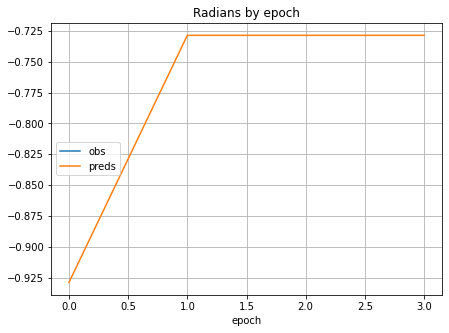

[-0.9287242257236663]
Prediction error in last 3 steps:  0.11999999999999994


In [13]:
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt

# observation, info = env.reset(seed=42)
obs_history = []
# fig,ax = plt.subplots(1,1)
# ax.set_xlabel('t')
# ax.set_ylabel('obs_idx_1')
# ax.set_xlim(0,20)
# ax.set_ylim(-5,5)

for _ in range(10):
    print("epoch #", _)
    observation, reward, terminated, truncated, info = env.step(env.action_space.sample())
    print(observation, reward, terminated, truncated, info)
    obs_history.append(observation[1])
    # plt.plot(obs_history[0][0])
    # plt.show()
    preds = obs_history[-1]+[0, 0.2,0.2,0.2]
    # obs_concat_preds = obs_history
    # for pred in preds:
    #     obs_concat_preds.append(pred)
    live_plot({"obs": obs_history, "preds": preds}, title="Radians by epoch")
    time.sleep(1)
    if terminated or truncated:
        print(obs_history)
        print("Prediction error in last 3 steps: ", forecast_error(obs_history[-3:], preds[-3:]))
        break
        # obs_history = []
        # observation, info = env.reset()

env.close()

The episode ends when any of the following happens:

Truncation: The episode duration reaches 1000 timesteps.

Termination: Any of the state space values is no longer finite.

Termination: The absolutely value of the vertical angle between the pole and the cart is greater than 0.2 radian. i.e. 11.4592 degrees

1; vertical angle of the pole on the cart; -Inf; Inf; angle (rad)

*JTBD*

- Run thousands of episodes to generate training data with features (current and prev angles and other data) and labels (next few angles)
- Train forecast model to predict trajectory of angle
- Start episode with control over speed i.e. time lag between steps
- Predict expected time to end of episode at step t with measure of uncertainty
- Predict trajectory of angle in next few time steps at step t
- At end of episode output prediction errors at a few time steps


In [14]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
import torch
X = torch.randn(1, 15)
print(X)

tensor([[ 0.8148,  1.3281, -0.0693,  0.3753,  1.4256, -0.0376,  0.7731, -0.4142,
         -2.3547, -0.2342, -1.0792, -0.0691,  0.7373, -0.5942, -0.6265]])


In [16]:
y = torch.ones(1, 10)
print(y)

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])


In [17]:
# y = softmax(layer2(layer1(X)))

from torch import nn

class TestNetwork(nn.Module):
  def __init__(self):
    super(TestNetwork, self).__init__()
    self.seqlayers = nn.Sequential(
        nn.Linear(15, 20),
        nn.ReLU(),
        nn.Linear(20, 10),
        nn.ReLU(),
    )
    self.softmax = nn.Softmax(dim=1)

  def forward(self, X):
    hidden1 = self.seqlayers(X)
    output = self.softmax(hidden1)
    return output



In [18]:
model = TestNetwork()
print(model)

TestNetwork(
  (seqlayers): Sequential(
    (0): Linear(in_features=15, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=10, bias=True)
    (3): ReLU()
  )
  (softmax): Softmax(dim=1)
)


In [19]:
preds = model(X)
preds

tensor([[0.0990, 0.0949, 0.1011, 0.0949, 0.0949, 0.1013, 0.1293, 0.0949, 0.0949,
         0.0949]], grad_fn=<SoftmaxBackward0>)

In [20]:
preds.size()

torch.Size([1, 10])

In [22]:
loss_ = torch.nn.functional.binary_cross_entropy(preds, y)
loss_

tensor(2.3070, grad_fn=<BinaryCrossEntropyBackward0>)

In [23]:
# Backpropagation for one step
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

optimizer.zero_grad()
loss_.backward()
optimizer.step()

new_preds = model(X)
new_loss = torch.nn.functional.binary_cross_entropy(new_preds, y)

print(new_loss)

tensor(2.3065, grad_fn=<BinaryCrossEntropyBackward0>)


In [85]:
# create a dataset with positions of the pendulum as features and time to terminate as label

import pandas as pd

columns = []
for i in range(8):
  columns.append(f'feature_{i}')
columns.append('time_to_terminate')

#create array
num_episodes = 1000
for j in range(num_episodes):
  episode_rows = create_rows_for_episode()
  if j == 0:
    arr = episode_rows
  else:
    arr = np.concatenate([arr, episode_rows], axis=0)
env.close()

df = pd.DataFrame(arr, columns=columns)
print(df.head())
print(df.describe())
print(df.info())

   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   0.071519  -0.048581   0.102439   0.998819   0.994739   0.576364   
1   0.100611  -0.116246   0.181770   0.993220   0.983341   0.590153   
2   0.141571  -0.217298   0.313715   0.976105   0.949517   1.047231   
3   0.173170  -0.317457   0.463109   0.948273   0.886301   0.225468   
4   0.224770  -0.460638   0.650918   0.887588   0.759148   1.812690   

   feature_6  feature_7  time_to_terminate  
0  -1.268870   1.379942                6.0  
1  -1.472330   1.878447                5.0  
2  -2.631056   3.557178                4.0  
3  -1.598550   3.114915                3.0  
4  -4.484055   5.516825                2.0  
         feature_0    feature_1    feature_2    feature_3    feature_4  \
count  6345.000000  6345.000000  6345.000000  6345.000000  6345.000000   
mean      0.059350    -0.043502     0.074882     0.887404     0.816424   
std       0.225101     0.435388     0.533039     0.145228     0.209202   
min    

In [83]:
def create_rows_for_episode():
  env.reset(seed=42)
  for _ in range(100):
    observation, reward, terminated, truncated, info = env.step(env.action_space.sample())
    features = np.array(observation[:8]).reshape(1, 8)
    if _ == 0:
      rows_for_ep = features
    else:
      rows_for_ep = np.concatenate((rows_for_ep, features), axis=0)
    if terminated or truncated:
      labels = np.array(range(_, -1,-1)).reshape(_+1, 1)
      assert len(labels) == len(rows_for_ep)
      rows_for_ep = np.concatenate((rows_for_ep, labels), axis=1)
      # print(len(rows_for_ep), type(rows_for_ep))
      return rows_for_ep
  
    

In [86]:
# terminating conditions of the episodes

df_terminated = df[df['time_to_terminate']==0]
print(df_terminated.head())
print(df_terminated.describe())
print(df_terminated.info())

    feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
6    0.484760  -0.868835   0.925419   0.495102   0.378946   2.852876   
13   0.031782  -0.427676   0.920028   0.903932   0.391853  -2.039096   
25  -0.359409   0.773237  -0.769555   0.634117   0.638581   0.944633   
31   0.263222  -0.691812   0.943809   0.722078   0.330491   0.399406   
36   0.547152  -0.848572   0.830892   0.529080   0.556433   2.342772   

    feature_6  feature_7  time_to_terminate  
6   -6.310496   3.144574                0.0  
13   0.624928   4.981520                0.0  
25   2.470864  -6.163354                0.0  
31  -3.379492   5.842487                0.0  
36  -5.953180   4.154613                0.0  
         feature_0    feature_1    feature_2    feature_3    feature_4  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.079051    -0.093281     0.109334     0.629364     0.464333   
std       0.414601     0.759185     0.863539     0.139403     0.16587